## Installing dependencies

In [ ]:
!pip install autointent openai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd

import importlib.resources as ires
import datasets

from autointent import Dataset

from autointent.modules.scoring import LinearScorer
from autointent.modules.decision import ArgmaxDecision

from autointent.metrics import decision_accuracy, decision_precision, \
    decision_recall, decision_f1, decision_roc_auc
from autointent.metrics import scoring_accuracy, scoring_precision, \
    scoring_recall, scoring_f1, scoring_roc_auc

from autointent.generation import Generator
from autointent.generation.utterances import UtteranceEvolver
from autointent.generation.chat_templates import GoofyEvolution, InformalEvolution
from autointent.generation.utterances import UtteranceGenerator
from autointent.generation.chat_templates import EnglishSynthesizerTemplate

from tqdm.notebook import tqdm
from copy import deepcopy

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "<YOUR_API_KEY>"

In [ ]:
datasets.logging.disable_progress_bar()

## Baseline

### Loading data

In [ ]:
dataset = Dataset.from_hub("AutoIntent/snips")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.19k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/366k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/43.3k [00:00<?, ?B/s]

intents-00000-of-00001.parquet:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

In [ ]:
dataset

{'train': Dataset({
     features: ['utterance', 'label'],
     num_rows: 13084
 }),
 'test': Dataset({
     features: ['utterance', 'label'],
     num_rows: 1400
 })}

In [ ]:
dataset['train'][0]

{'utterance': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist',
 'label': 0}

### Composing scorer

In [ ]:
scorer = LinearScorer(
    embedder_config="sergeyzh/rubert-tiny-turbo",
)

scorer.fit(dataset['train']['utterance'], dataset['train']['label'])

modules.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/431k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/196 [00:00<?, ?B/s]

In [ ]:
scorer.predict(['hello, world!', 'goodbye!'])

array([[2.19398163e-04, 5.45256531e-04, 1.97540273e-01, 4.07960412e-02,
        8.95144936e-03, 7.50773394e-01, 1.17418748e-03],
       [3.67181611e-03, 3.84595742e-03, 1.48773777e-01, 1.79503111e-01,
        2.32520673e-03, 6.19926663e-01, 4.19534689e-02]])

### Evaluating

In [ ]:
test_preds_proba = scorer.predict(dataset['test']['utterance'])

In [ ]:
print("Baseline results")
print(f"Accuracy: {scoring_accuracy(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Precision: {scoring_precision(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Recall: {scoring_recall(dataset['test']['label'], test_preds_proba):.4f}")
print(f"F1: {scoring_f1(dataset['test']['label'], test_preds_proba):.4f}")

Baseline results
Accuracy: 0.9771
Precision: 0.9773
Recall: 0.9771
F1: 0.9772


## 5-shot

### Composing data

In [ ]:
utterances = []
labels = []

for label in np.unique(dataset['train']['label']):
  label_col = dataset['train'].filter(lambda x: x['label'] == label)
  samples = np.random.choice(label_col, size=5)
  utterances.extend(list(sample['utterance'] for sample in samples))
  labels.extend(list(sample['label'] for sample in samples))

In [ ]:
data_dict = {
    'train': [{
        'utterance': utterance,
        'label': label
    } for utterance, label in zip(utterances, labels)],

    'test': [{
        'utterance': utterance,
        'label': label
    } for utterance, label in zip(dataset['test']['utterance'], dataset['test']['label'])]
}

In [ ]:
dataset5 = Dataset.from_dict(data_dict)
dataset5.intents = dataset.intents

In [ ]:
dataset5

{'train': Dataset({
     features: ['utterance', 'label'],
     num_rows: 35
 }),
 'test': Dataset({
     features: ['utterance', 'label'],
     num_rows: 1400
 })}

### Composing scorer

In [ ]:
scorer = LinearScorer(
    embedder_config="sergeyzh/rubert-tiny-turbo",
)

scorer.fit(dataset5['train']['utterance'], dataset5['train']['label'])

### Evaluating

In [ ]:
test_preds_proba = scorer.predict(dataset5['test']['utterance'])

In [ ]:
print("5-shot results")
print(f"Accuracy: {scoring_accuracy(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Precision: {scoring_precision(dataset['test']['label'], test_preds_proba):.4f}")
print(f"Recall: {scoring_recall(dataset['test']['label'], test_preds_proba):.4f}")
print(f"F1: {scoring_f1(dataset['test']['label'], test_preds_proba):.4f}")

5-shot results
Accuracy: 0.8121
Precision: 0.8125
Recall: 0.8121
F1: 0.8067


## Augmentations (Evolver)

### Processing augmentations

In [ ]:
dataset5_evolver_aug = deepcopy(dataset5)

In [ ]:
generator = Generator(
    base_url="http://193.187.173.33:8002/api/providers/openai/v1",
    model_name="gpt-3.5-turbo"
)

evolver = UtteranceEvolver(generator, prompt_makers=[GoofyEvolution(), InformalEvolution()])

In [ ]:
evolver.augment(dataset5_evolver_aug)

Dataset({
    features: ['label', 'utterance'],
    num_rows: 35
})

In [ ]:
dataset5_evolver_aug

{'train': Dataset({
     features: ['utterance', 'label'],
     num_rows: 70
 }),
 'test': Dataset({
     features: ['utterance', 'label'],
     num_rows: 1400
 })}

### Composing scorer

In [ ]:
scorer = LinearScorer(
    embedder_config="sergeyzh/rubert-tiny-turbo",
)

scorer.fit(
    dataset5_evolver_aug['train']['utterance'],
    dataset5_evolver_aug['train']['label']
)

### Evaluating

In [ ]:
test_preds_proba = scorer.predict(dataset5_evolver_aug['test']['utterance'])

In [ ]:
print("Augmentation (evolver) results")
print(f"Accuracy: {scoring_accuracy(dataset5_evolver_aug['test']['label'], test_preds_proba):.4f}")
print(f"Precision: {scoring_precision(dataset5_evolver_aug['test']['label'], test_preds_proba):.4f}")
print(f"Recall: {scoring_recall(dataset5_evolver_aug['test']['label'], test_preds_proba):.4f}")
print(f"F1: {scoring_f1(dataset5_evolver_aug['test']['label'], test_preds_proba):.4f}")

Augmentation (evolver) results
Accuracy: 0.8264
Precision: 0.8256
Recall: 0.8264
F1: 0.8218


## Augmentations (Generator)

### Processing augmentations

In [ ]:
dataset5_generator_aug = deepcopy(dataset5)

In [ ]:
generator = Generator(
    base_url="http://193.187.173.33:8002/api/providers/openai/v1",
    model_name="gpt-3.5-turbo"
)

prompt = EnglishSynthesizerTemplate(dataset5_generator_aug)
augmenter = UtteranceGenerator(generator, prompt_maker=prompt)

In [ ]:
augmenter.augment(dataset5_generator_aug)

[Sample(utterance='Add the song "Dance Monkey" to my Workout playlist.', label=0),
 Sample(utterance='Put this track on my Chill Vibes playlist.', label=0),
 Sample(utterance='Add the new album "Golden Hour" to my Favorites playlist.', label=0),
 Sample(utterance='Add the latest single by Ed Sheeran to my Top Hits playlist.', label=0),
 Sample(utterance='Include the song "Unstoppable" in my Motivation Mix playlist.', label=0),
 Sample(utterance='Add a track from the 80s to my Retro Jams playlist.', label=0),
 Sample(utterance='Put this tune on my Road Trip playlist.', label=0),
 Sample(utterance='Add a classical piece to my Study Music playlist.', label=0),
 Sample(utterance='Include a jazz standard in my Relaxation playlist.', label=0),
 Sample(utterance='Add the artist Sia to my Female Vocalists playlist.', label=0),
 Sample(utterance='Reserve a table at a French bistro in downtown LA for 4 people.', label=1),
 Sample(utterance="I'd like to book a restaurant that serves sushi in San 

In [ ]:
dataset5_generator_aug

{'train': Dataset({
     features: ['utterance', 'label'],
     num_rows: 80
 }),
 'test': Dataset({
     features: ['utterance', 'label'],
     num_rows: 1400
 })}

### Composing scorer

In [ ]:
scorer = LinearScorer(
    embedder_config="sergeyzh/rubert-tiny-turbo",
)

scorer.fit(
    dataset5_generator_aug['train']['utterance'],
    dataset5_generator_aug['train']['label']
)

### Evaluating

In [ ]:
test_preds_proba = scorer.predict(dataset5_generator_aug['test']['utterance'])

In [ ]:
print("Augmentation (generator) results")
print(f"Accuracy: {scoring_accuracy(dataset5_generator_aug['test']['label'], test_preds_proba):.4f}")
print(f"Precision: {scoring_precision(dataset5_generator_aug['test']['label'], test_preds_proba):.4f}")
print(f"Recall: {scoring_recall(dataset5_generator_aug['test']['label'], test_preds_proba):.4f}")
print(f"F1: {scoring_f1(dataset5_generator_aug['test']['label'], test_preds_proba):.4f}")

Augmentation (generator) results
Accuracy: 0.8536
Precision: 0.8526
Recall: 0.8536
F1: 0.8474


## Experiment (optimal shots number)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Dict, List

In [ ]:
%config InlineBackend.figure_formats = ['svg', 'png']
%matplotlib inline

In [ ]:
def get_random_samples(
    dataset: datasets.Dataset, n_shots: int
) -> Dict[str, List[Dict[str, str | int]]]:
    """
    Choose random n_shots for each class from train split of the dataset
    Test split is left untouched
    """
    utterances = []
    labels = []
    for label in np.unique(dataset['train']['label']):
        label_col = dataset['train'].filter(lambda x: x['label'] == label)
        samples = np.random.choice(label_col, size=n_shots)
        utterances.extend(list(sample['utterance'] for sample in samples))
        labels.extend(list(sample['label'] for sample in samples))

    data_dict = {
        'train': [{
            'utterance': utterance,
            'label': label
        } for utterance, label in zip(utterances, labels)],

        'test': [{
            'utterance': utterance,
            'label': label
        } for utterance, label in zip(dataset['test']['utterance'], dataset['test']['label'])]
    }

    return data_dict

In [ ]:
def get_statistics(
    dataset: datasets.Dataset, n_shots: int, n_launches: int = 7,
    augment: bool = False, verbose: bool = True
) -> Dict[str, List[float]]:
    """
    Make n_launches runs on random part of size n_shots of the train split
        of the dataset and get metric statistics
    """
    result = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    rng = range(n_launches)
    if verbose:
      rng = tqdm(rng)

    for launch in rng:
        data_dict = get_random_samples(dataset, n_shots)
        fewshot_dataset = Dataset.from_dict(data_dict)
        fewshot_dataset.intents = dataset.intents

        if augment:
            generator = Generator(
                base_url="http://193.187.173.33:8002/api/providers/openai/v1",
                model_name="gpt-3.5-turbo"
            )
            prompt = EnglishSynthesizerTemplate(fewshot_dataset)
            augmenter = UtteranceGenerator(generator, prompt_maker=prompt)
            augmenter.augment(fewshot_dataset)

        scorer = LinearScorer(
            embedder_config="sergeyzh/rubert-tiny-turbo",
        )
        scorer.fit(
            fewshot_dataset['train']['utterance'],
            fewshot_dataset['train']['label']
        )

        test_scores = scorer.predict(fewshot_dataset['test']['utterance'])
        result['Accuracy'].append(
            scoring_accuracy(fewshot_dataset['test']['label'], test_scores)
        )
        result['Precision'].append(
            scoring_precision(fewshot_dataset['test']['label'], test_scores)
        )
        result['Recall'].append(
            scoring_recall(fewshot_dataset['test']['label'], test_scores)
        )
        result['F1'].append(
            scoring_f1(fewshot_dataset['test']['label'], test_scores)
        )

    return result

In [ ]:
shots_values = [5, 10, 20, 50, 100]
stats = {}

for n_shots in shots_values:
    stats[n_shots] = get_statistics(
        dataset, n_shots
    )

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
aug_stats = {}

for n_shots in shots_values:
    aug_stats[n_shots] = get_statistics(
        dataset, n_shots, augment=True
    )

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
accs = {}
aug_accs = {}

for shot_val in shots_values:
    accs[shot_val] = stats[shot_val]['Accuracy']
    aug_accs[shot_val] = aug_stats[shot_val]['Accuracy']

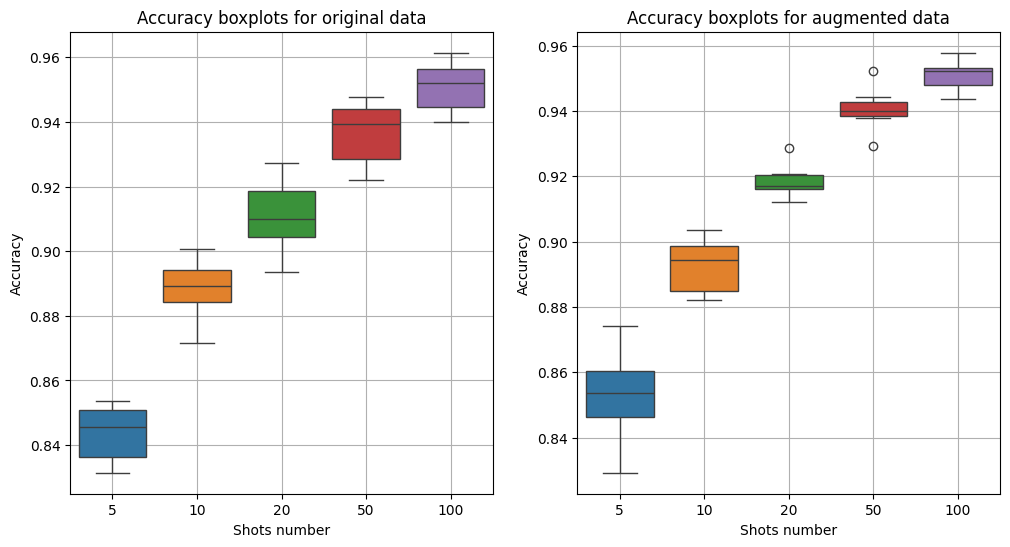

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(accs, ax=axes[0])
sns.boxplot(aug_accs, ax=axes[1])

axes[0].set_title('Accuracy boxplots for original data')
axes[1].set_title('Accuracy boxplots for augmented data')

for ax in range(2):
    axes[ax].set_xlabel("Shots number")
    axes[ax].set_ylabel("Accuracy")
    axes[ax].grid(True)

plt.savefig('exp0_acc.png')
plt.show()

In [ ]:
prcs = {}
aug_prcs = {}

for shot_val in shots_values:
    prcs[shot_val] = stats[shot_val]['Precision']
    aug_prcs[shot_val] = aug_stats[shot_val]['Precision']

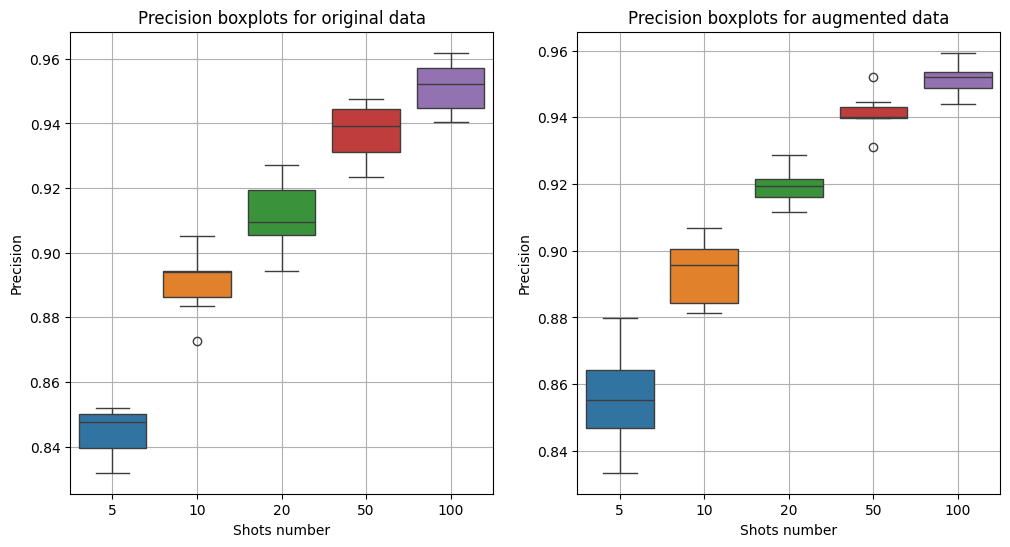

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(prcs, ax=axes[0])
sns.boxplot(aug_prcs, ax=axes[1])

axes[0].set_title('Precision boxplots for original data')
axes[1].set_title('Precision boxplots for augmented data')

for ax in range(2):
    axes[ax].set_xlabel("Shots number")
    axes[ax].set_ylabel("Precision")
    axes[ax].grid(True)

plt.savefig('exp0_prc.png')
plt.show()

In [ ]:
rcls = {}
aug_rcls = {}

for shot_val in shots_values:
    rcls[shot_val] = stats[shot_val]['Recall']
    aug_rcls[shot_val] = aug_stats[shot_val]['Recall']

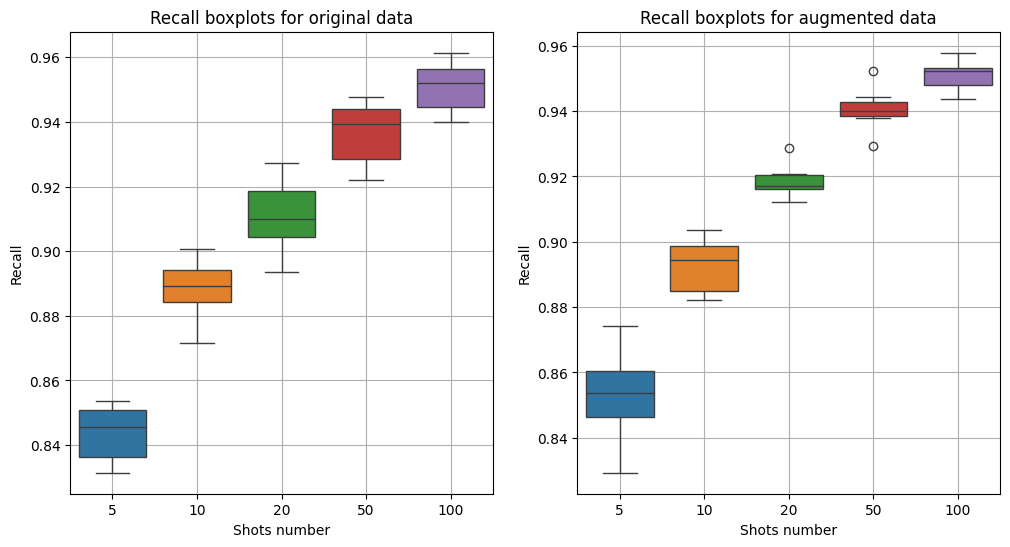

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(rcls, ax=axes[0])
sns.boxplot(aug_rcls, ax=axes[1])

axes[0].set_title('Recall boxplots for original data')
axes[1].set_title('Recall boxplots for augmented data')

for ax in range(2):
    axes[ax].set_xlabel("Shots number")
    axes[ax].set_ylabel("Recall")
    axes[ax].grid(True)

plt.savefig('exp0_rcl.png')
plt.show()

In [ ]:
f1s = {}
aug_f1s = {}

for shot_val in shots_values:
    f1s[shot_val] = stats[shot_val]['F1']
    aug_f1s[shot_val] = aug_stats[shot_val]['F1']

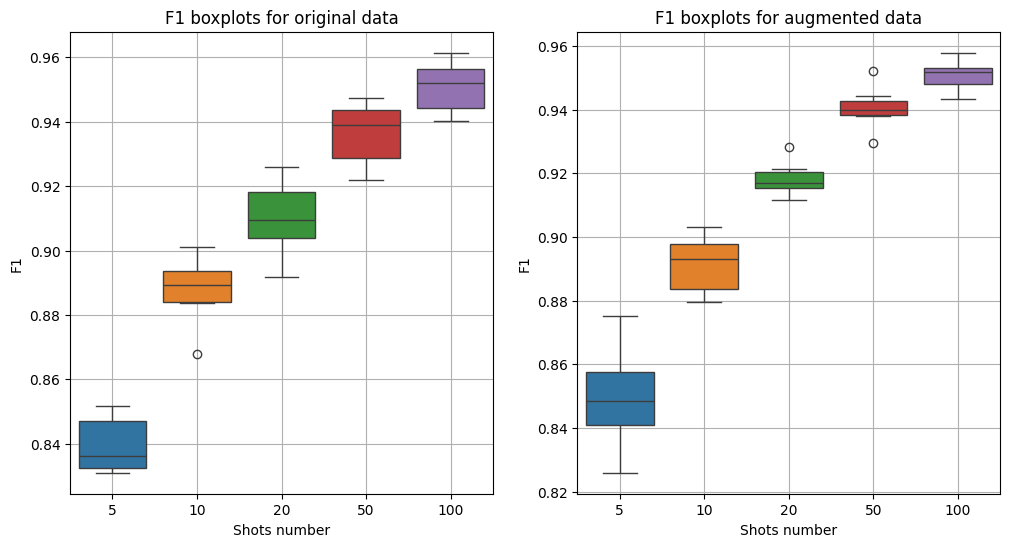

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(f1s, ax=axes[0])
sns.boxplot(aug_f1s, ax=axes[1])

axes[0].set_title('F1 boxplots for original data')
axes[1].set_title('F1 boxplots for augmented data')

for ax in range(2):
    axes[ax].set_xlabel("Shots number")
    axes[ax].set_ylabel("F1")
    axes[ax].grid(True)

plt.savefig('exp0_f1.png')
plt.show()

## Custom augmentations (Critic for prompt generation)

In [ ]:
from autointent.generation import Generator
from autointent.generation.chat_templates._evolution_templates_schemas import Message, Role
from autointent.schemas import Intent, Sample
from autointent import Dataset
from autointent.custom_types import Split
from datasets import Dataset as HFDataset
from datasets import concatenate_datasets

from typing import List, ClassVar, Optional

import random

In [ ]:
class BaseCriticTemplate:

    _GENERATE_INSTRUCTION: ClassVar[str]

    def __init__(self) -> None:
        return

    def __call__(self, intent_data: Intent, prompt: str) -> List[Message]:
        content = self._GENERATE_INSTRUCTION.format(
            intent_name=intent_data.name, prompt=prompt
        )

        return [Message(role=Role.USER, content=content)]

In [ ]:
class EnglishCriticTemplate(BaseCriticTemplate):

    _GENERATE_INSTRUCTION: ClassVar[str] = \
    "You are a professional prompt engineer. You have to help your colleague with his prompt engineering task. " \
    "The task is to construct a prompt that will make an LLM generate new samples for the dataset. " \
    "Dataset consists of utterances (texts) and labels that correspond to them (intents). " \
    "Separate prompt is constructed for each intent to enrich the original data with LLM-generated utterances of particular intent. " \
    "You will be given the current prompt for intent {intent_name}. " \
    "You have to criticize this prompt and suggest ideas for improving it. " \
    "Prompt: {prompt}"

In [ ]:
class BasePromptGeneratorTemplate:

    _GENERATE_INITIAL_INSTRUCTION: ClassVar[str]
    _GENERATE_INSTRUCTION: ClassVar[str]

    def __init__(
        self, dataset: Dataset, split: str = Split.TRAIN,
        max_sample_utterances: Optional[int] = None
    ) -> None:
        self.dataset = dataset
        self.split = split
        self.max_sample_utterances = max_sample_utterances
        self.initial_examples = ""

    def __call__(
        self, intent_data: Intent, critic_text: Optional[str], n_examples: int
    ) -> List[Message]:
        if critic_text is not None:
            new_message = self._generate_message(critic_text)
            return [new_message]

        in_domain_samples = self.dataset[self.split].filter(
            lambda sample: sample[Dataset.label_feature] is not None
        )
        if self.dataset.multilabel:
            filter_fn = lambda sample: sample[Dataset.label_feature][intent_data.id] == 1
        else:
            filter_fn = lambda sample: sample[Dataset.label_feature] == intent_data.id

        filtered_split = in_domain_samples.filter(filter_fn)
        sample_utterances = filtered_split[Dataset.utterance_feature]

        if self.max_sample_utterances is not None and len(sample_utterances) > self.max_sample_utterances:
            sample_utterances = random.sample(sample_utterances, k=self.max_sample_utterances)

        message = self._generate_initial_message(
            intent_data, sample_utterances, n_examples
        )
        return [message]

    def _generate_message(self, critic_text: str) -> Message:
        content = self._GENERATE_INSTRUCTION.format(
            critic_text=critic_text, initial_examples=self.initial_examples
        )
        return Message(role=Role.USER, content=content)

    def _generate_initial_message(
        self, intent_data: Intent, samples: List[str], n_examples: int
    ) -> Message:
        initial_examples = ""
        for idx, sample in enumerate(samples):
            initial_examples += f"{idx + 1}. {sample} \n "
        self.initial_examples = initial_examples

        content = self._GENERATE_INITIAL_INSTRUCTION.format(
            intent_name=intent_data.name,
            initial_examples=initial_examples,
            n_examples=n_examples
        )
        return Message(role=Role.USER, content=content)

In [ ]:
class EnglishPromptGeneratorTemplate(BasePromptGeneratorTemplate):

    _GENERATE_INITIAL_INSTRUCTION: ClassVar[str] = \
    "You are a professional prompt engineer. " \
    "You have to construct a prompt that will make an LLM generate new samples for the dataset. " \
    "Dataset consists of utterances (texts) and labels that correspond to them (intents). " \
    "Separate prompt is constructed for each intent to enrich the original data with LLM-generated utterances of particular intent. " \
    "You have to construct a prompt for intent {intent_name}. LLM should return exactly {n_examples} new enumerated utterances. " \
    "Generated utterances should have the same style as examples listed below, but they should differ from them so that " \
    "generated data would bring some variety to the dataset. " \
    "You can use in your prompt the following utterances examples from the original dataset: \n " \
    "{initial_examples} \n " \
    "Return only constructed prompt."

    _GENERATE_INSTRUCTION: ClassVar[str] = \
    "Your colleague reviewed your prompt and provided some remarks and suggestions for improvement. " \
    "Improve your prompt using this information. \n " \
    "Review: {critic_text} \n " \
    "Do not forget to use the following examples in your prompt: \n " \
    "{initial_examples} \n "
    "Return only constructed prompt."

In [ ]:
HIST = []

In [ ]:
class PromptCriticGenerator:
    def __init__(
        self, generator: Generator, prompt_maker: BasePromptGeneratorTemplate,
        critic_prompt_maker: BaseCriticTemplate, async_mode: bool = False
    ) -> None:
        """
        Generation of new utterances based on existing ones using the prompt
        that was generated using agent-criticism mechanism
        """
        self.generator = generator
        self.prompt_maker = prompt_maker
        self.critic_prompt_maker = critic_prompt_maker
        self.async_mode = async_mode

    def __call__(
        self, intent_data: Intent, n_generations: int, n_hops: int
    ) -> List[str]:
        """
        Call the generator to generate new utterances
        """
        messages = self.prompt_maker(intent_data, None, n_generations)
        response_text = self.generator.get_chat_completion(messages)
        messages.append(Message(role=Role.ASSISTANT, content=response_text))

        for hop in range(n_hops):
            critic_messages = self.critic_prompt_maker(
                intent_data, response_text
            )
            critic_response_text = self.generator.get_chat_completion(critic_messages)
            cur_messages = self.prompt_maker(
                intent_data, critic_response_text, n_generations
            )
            messages.extend(cur_messages)
            response_text = self.generator.get_chat_completion(messages)
            messages.append(Message(role=Role.ASSISTANT, content=response_text))

        final_message = [Message(role=Role.USER, content=response_text)]
        final_response_text = self.generator.get_chat_completion(final_message)

        HIST.append(messages)
        return _extract_utterances(final_response_text)

    def augment(
        self, dataset: Dataset, split_name: str = Split.TRAIN,
        n_generations: int = 5, n_hops: int = 3, update_split: bool = True
    ) -> List[Sample]:
        """
        Apply augmentations to the dataset
        """
        original_split = dataset[split_name]
        new_samples = []
        for intent in dataset.intents:
            generated_utterances = self(
                intent_data=intent, n_generations=n_generations, n_hops=n_hops
            )
            new_samples.extend([
                {
                    Dataset.label_feature: intent.id,
                    Dataset.utterance_feature: utterance
                } for utterance in generated_utterances
            ])

        if update_split:
            generated_split = HFDataset.from_list(new_samples)
            dataset[split_name] = concatenate_datasets([
                original_split, generated_split
            ])

        return [Sample(**sample) for sample in new_samples]

In [ ]:
def _extract_utterances(response_text: str) -> list[str]:
    """Extract utterances from LLM output.

    Args:
        response_text: Response text from LLM.

    Returns:
        List of utterances.
    """
    raw_utterances = response_text.split("\n")
    res = [ut[ut.find(" ") + 1 :] if " " in ut else ut for ut in raw_utterances]
    final = []
    for ut in res:
        words = ut.lower().split()
        if not ('feedback' in words or 'utterance' in words or
                'utterances' in words or 'AI' in words) and len(ut) > 0:
            final.append(ut)
    return final

### Applying augmentations

In [ ]:
dataset5_aug = deepcopy(dataset5)

In [ ]:
generator = Generator(
    base_url="http://193.187.173.33:8002/api/providers/openai/v1",
    model_name="gpt-3.5-turbo",
    max_tokens=1000
)

prompter = EnglishPromptGeneratorTemplate(dataset5_aug)
critic = EnglishCriticTemplate()
augmenter = PromptCriticGenerator(generator, prompter, critic)

In [ ]:
augmenter.augment(dataset5_aug, n_generations=5, n_hops=3)

[Sample(utterance='Add A Bum Note and a Bead of Sweat to my Stress Relief playlist for some quirky and fun tunes to lighten the mood.', label=0),
 Sample(utterance='Put this tune on my your favorite coffeehouse playlist to create a cozy and laid-back atmosphere perfect for a chill afternoon.', label=0),
 Sample(utterance='Add track to my playlist a sudden rainstorm to capture the essence of a refreshing downpour with soothing melodies and calming sounds.', label=0),
 Sample(utterance='Add Ace Hood to the this is Aretha Franklin playlist for a mix of classic soul and contemporary rap to spice things up.', label=0),
 Sample(utterance='Add tune to Reggae Infusions for a fusion of reggae beats with other genres, perfect for a unique and eclectic listening experience.', label=0),
 Sample(utterance='I would like to make a reservation at "Bella\'s Bistro" in San Francisco, a quaint Italian eatery renowned for its homemade pasta dishes and cozy ambiance, for a party of four next Saturday eveni

In [ ]:
dataset5_aug

{'train': Dataset({
     features: ['utterance', 'label'],
     num_rows: 77
 }),
 'test': Dataset({
     features: ['utterance', 'label'],
     num_rows: 1400
 })}

### Composing scorer

In [ ]:
scorer = LinearScorer(
    embedder_config="sergeyzh/rubert-tiny-turbo",
)

scorer.fit(
    dataset5_aug['train']['utterance'],
    dataset5_aug['train']['label']
)

### Evaluating results

In [ ]:
test_preds_proba = scorer.predict(dataset5_aug['test']['utterance'])

In [ ]:
print("Augmentation (custom) results")
print(f"Accuracy: {scoring_accuracy(dataset5_aug['test']['label'], test_preds_proba):.4f}")
print(f"Precision: {scoring_precision(dataset5_aug['test']['label'], test_preds_proba):.4f}")
print(f"Recall: {scoring_recall(dataset5_aug['test']['label'], test_preds_proba):.4f}")
print(f"F1: {scoring_f1(dataset5_aug['test']['label'], test_preds_proba):.4f}")

Augmentation (custom) results
Accuracy: 0.8257
Precision: 0.8355
Recall: 0.8257
F1: 0.8189


In [ ]:
accs_new, prcs_new, rcls_new, f1s_new = [], [], [], []

for _ in tqdm(range(7)):
    data_dict = get_random_samples(dataset, 5)
    fewshot_dataset = Dataset.from_dict(data_dict)
    fewshot_dataset.intents = dataset.intents

    prompter = EnglishPromptGeneratorTemplate(fewshot_dataset)
    critic = EnglishCriticTemplate()
    augmenter = PromptCriticGenerator(generator, prompter, critic)

    augmenter.augment(fewshot_dataset)

    scorer = LinearScorer(
        embedder_config="sergeyzh/rubert-tiny-turbo",
    )
    scorer.fit(
        fewshot_dataset['train']['utterance'],
        fewshot_dataset['train']['label']
    )
    test_preds_proba = scorer.predict(fewshot_dataset['test']['utterance'])

    accs_new.append(scoring_accuracy(fewshot_dataset['test']['label'], test_preds_proba))
    prcs_new.append(scoring_precision(fewshot_dataset['test']['label'], test_preds_proba))
    rcls_new.append(scoring_recall(fewshot_dataset['test']['label'], test_preds_proba))
    f1s_new.append(scoring_f1(fewshot_dataset['test']['label'], test_preds_proba))

  0%|          | 0/7 [00:00<?, ?it/s]

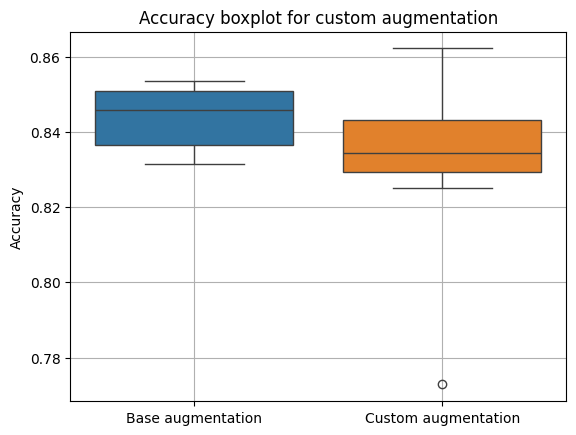

In [ ]:
sns.boxplot([accs[5], accs_new])

plt.grid(True)
plt.title('Accuracy boxplot for custom augmentation')
plt.ylabel("Accuracy")

plt.xticks([0, 1], ['Base augmentation', 'Custom augmentation'])

plt.savefig('exp1_acc.png')
plt.show()

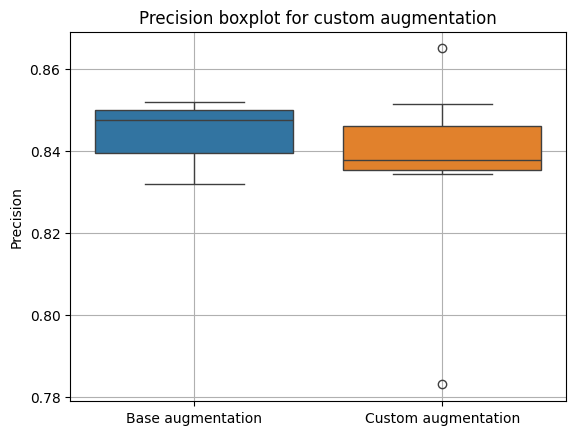

In [ ]:
sns.boxplot([prcs[5], prcs_new])

plt.grid(True)
plt.title('Precision boxplot for custom augmentation')
plt.ylabel("Precision")

plt.xticks([0, 1], ['Base augmentation', 'Custom augmentation'])

plt.savefig('exp1_prc.png')
plt.show()

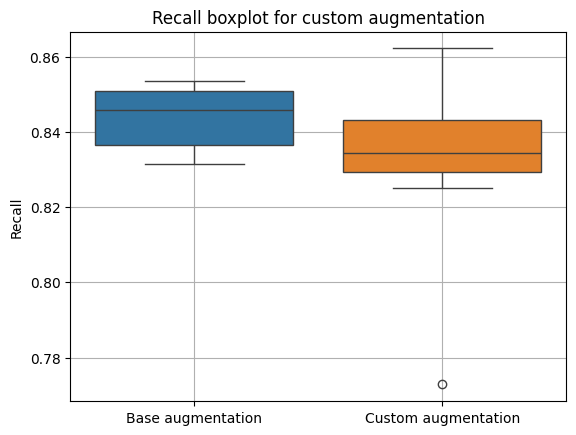

In [ ]:
sns.boxplot([rcls[5], rcls_new])

plt.grid(True)
plt.title('Recall boxplot for custom augmentation')
plt.ylabel("Recall")

plt.xticks([0, 1], ['Base augmentation', 'Custom augmentation'])

plt.savefig('exp1_rcl.png')
plt.show()

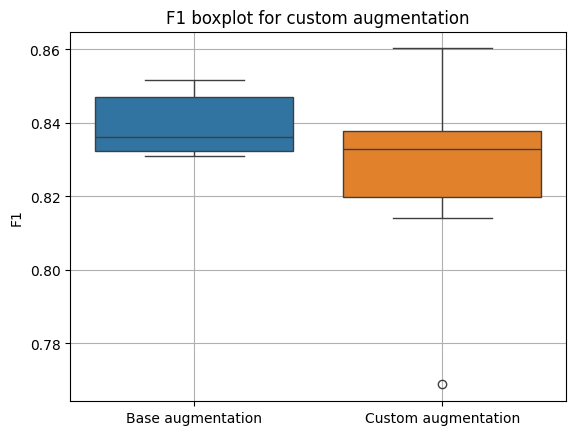

In [ ]:
sns.boxplot([f1s[5], f1s_new])

plt.grid(True)
plt.title('F1 boxplot for custom augmentation')
plt.ylabel("F1")

plt.xticks([0, 1], ['Base augmentation', 'Custom augmentation'])

plt.savefig('exp1_f1.png')
plt.show()